In [30]:
%load_ext autoreload
%autoreload 2


from IPython.display import Video
from ultralytics import YOLO
import cv2
import os
from segmentation import BasketballSegmentation
import matplotlib.pyplot as plt
import numpy as np
from overlay_traj import BasketballTrajectory3D
# Be cautious that processing a long video without a gpu will take some time.
video_path = 'only_shot.mp4'
Video(video_path, width=640, height=360)
model_path = "best2.pt"
yolo_output_folder = "yolo_output_folder"
hough_output_folder = "hough_output_folder"
output_video = "overlay.mp4"
os.makedirs(yolo_output_folder, exist_ok=True)
frames_dir = os.path.join(yolo_output_folder, "images")
labels_dir = os.path.join(yolo_output_folder, "labels")
os.makedirs(frames_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run yolo on this video

In [31]:
# Load YOLO model
model = YOLO(model_path)

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
output_video_path = os.path.join(yolo_output_folder, "yolo_output.mp4")
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    result = results[0]
# Filter boxes before drawing or saving
    filtered_boxes = []
    for box in result.boxes:
        cls = int(box.cls[0])
        print(cls)
        if cls == 1:
            continue  # skip rims
        filtered_boxes.append(box)

    # If multiple basketballs (class 0), keep only first
    if len(filtered_boxes) > 1:
        filtered_boxes = filtered_boxes[:1]
    # Save image
    img_name = f"frame_{frame_idx:05d}.jpg"
    img_path = os.path.join(frames_dir, img_name)
    cv2.imwrite(img_path, frame)

    # Write cleaned YOLO label
    label_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        for box in filtered_boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            x_center, y_center, w, h = map(float, box.xywhn[0])
            f.write(f"{cls} {x_center} {y_center} {w} {h} {conf}\n")

    # Draw boxes for output video (cleaned)
    annotated_frame = frame.copy()
    for box in filtered_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    out.write(annotated_frame)

    frame_idx += 1
    if frame_idx % 20 == 0:
        print(f"Processed frame {frame_idx}")

cap.release()
out.release()

print(f"\nCleaned and saved results to: {yolo_output_folder}")
print(f"- Frames: {frames_dir}")
print(f"- Labels: {labels_dir}")
print(f"- Video: {output_video_path}")
Video(output_video_path, width=640, height=360)


0: 256x416 1 basketball, 50.6ms
Speed: 2.1ms preprocess, 50.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 44.8ms
Speed: 1.3ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 33.0ms
Speed: 1.3ms preprocess, 33.0ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 35.7ms
Speed: 1.5ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 49.9ms
Speed: 1.9ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 33.7ms
Speed: 1.3ms preprocess, 33.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 416)
0

0: 256x416 1 basketball, 40.5ms
Speed: 1.4ms preprocess, 40.5ms inference, 

In [34]:
segmentation = BasketballSegmentation(yolo_output_folder, hough_output_folder)

radii = segmentation.process_folder()
print("\nAll detected radii:", radii)

Saved: hough_output_folder/frame_00000_processed.jpg | radius=22
22
Saved: hough_output_folder/frame_00001_processed.jpg | radius=22
22
Saved: hough_output_folder/frame_00002_processed.jpg | radius=22
22
Saved: hough_output_folder/frame_00003_processed.jpg | radius=26
26
Saved: hough_output_folder/frame_00004_processed.jpg | radius=29
29
Saved: hough_output_folder/frame_00005_processed.jpg | radius=23
23
Saved: hough_output_folder/frame_00006_processed.jpg | radius=24
24
Saved: hough_output_folder/frame_00007_processed.jpg | radius=23
23
Saved: hough_output_folder/frame_00008_processed.jpg | radius=24
24
Saved: hough_output_folder/frame_00009_processed.jpg | radius=21
21
Saved: hough_output_folder/frame_00010_processed.jpg | radius=26
26
Saved: hough_output_folder/frame_00011_processed.jpg | radius=28
28
Saved: hough_output_folder/frame_00012_processed.jpg | radius=25
25
Saved: hough_output_folder/frame_00013_processed.jpg | radius=27
27
Saved: hough_output_folder/frame_00014_processed

k = 578.613, b = 33.804


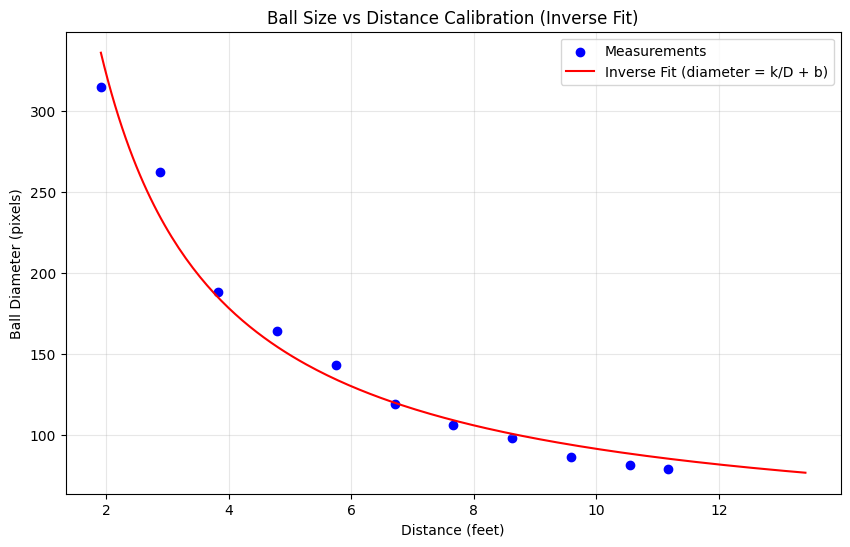

In [35]:
# --- Calibration (Inverse Model) ---
distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11.66]) * (11.5 / 12)  # in feet
diameters = np.array([314.78, 262.03, 188.0, 164.15, 143.57, 119.33, 106.08, 98.08, 86.47, 81.58, 79.10])  # in pixels

# Fit inverse model: diameter = k / D + b
inv_dist = 1 / distances
k, b = np.polyfit(inv_dist, diameters, 1)
print(f"k = {k:.3f}, b = {b:.3f}")

# Plot calibration and model
plt.figure(figsize=(10, 6))
plt.scatter(distances, diameters, color='blue', label='Measurements')

x_fit = np.linspace(min(distances), max(distances) * 1.2, 200)
plt.plot(x_fit, k / x_fit + b, 'r-', label='Inverse Fit (diameter = k/D + b)')

plt.xlabel('Distance (feet)')
plt.ylabel('Ball Diameter (pixels)')
plt.title('Ball Size vs Distance Calibration (Inverse Fit)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [36]:
# --- Convert radii to distances ---
def radius_to_distance(radius):
    diameter = 2 * radius
    D = k / (diameter - b)
    return D if D > 0 else np.nan

distances = [radius_to_distance(r) for r in radii]
print("Estimated distances (ft):", distances)

Estimated distances (ft): [56.750247478631195, 56.750247478631195, 56.750247478631195, 31.799306439685598, 23.913807706825217, 47.44371353486228, 40.75951668295635, 47.44371353486228, 40.75951668295635, 70.59888836240836, 31.799306439685598, 26.068613837279585, 35.7261682468042, 28.650203287138275, 31.799306439685598, 70.59888836240836, 31.799306439685598, 31.799306439685598, 35.7261682468042, 26.068613837279585, 35.7261682468042, 70.59888836240836, 40.75951668295635, 31.799306439685598, 31.799306439685598, 35.7261682468042, 35.7261682468042, 47.44371353486228, 35.7261682468042, 28.650203287138275, 56.750247478631195, 56.750247478631195, 28.650203287138275, 40.75951668295635, 31.799306439685598, 40.75951668295635, 31.799306439685598, 56.750247478631195, 35.7261682468042, 70.59888836240836, 40.75951668295635, 28.650203287138275, 31.799306439685598, 31.799306439685598, 22.08803253471339, 31.799306439685598, 40.75951668295635, 31.799306439685598, 35.7261682468042, 31.799306439685598, 40.7

In [37]:
labels_folder = "yolo_output_folder/labels"
img_width = 1920
img_height = 1080

# distances array from your calibration (in meters)
distances_m = np.array(distances) / 3.281
traj3d = BasketballTrajectory3D(video_path, labels_folder, img_width, img_height, distances=distances_m)
smooth_x, smooth_y, smooth_z, vel_m, acc_m, avg_speeds = traj3d.compute_trajectory()

# overlay video
output_path = "overlay_3d.mp4"
traj3d.overlay_video(output_path, show_z=True, show_vel=True, show_acc=True)

# display in notebook
Video(output_path, width=640, height=360)


Saved video: overlay_3d.mp4
